In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import torch
from PIL import Image
from diffusers import (
    DDIMScheduler, 
    UniPCMultistepScheduler,
    DPMSolverMultistepScheduler,
)
from denku import show_images, show_image

from instantid.pipelines.pipeline_instantid import StableDiffusionInstantPipeline
from instantid.utils.load_components import load_face_app, load_pipeline_components, prepare_face_embeddings, load_additional_unet
from instantid.utils.util import resize_max_side_to_target
from instantid.utils.style_template import update_prompt_for_style

%load_ext autoreload
%autoreload 2

In [2]:
pretrained_model_path = './models/stable-diffusion-v1-5'
instantid_components_path = './models/instantid-components'

adapter_ckpt_path = os.path.join(instantid_components_path, 'ip-state.ckpt')
image_proj_ckpt_path = os.path.join(instantid_components_path, 'image_proj.ckpt')
controlnet_ckpt_path = os.path.join(instantid_components_path, 'controlnet.ckpt')

additional_unet_path = None
additional_unet_path = './models/additional-unets/epicphotogasm_lastUnicorn.safetensors'
# additional_unet_path = './models/additional-unets/aniflatmixAnimeFlatColorStyle_v20.safetensors'
# additional_unet_path = './models/additional-unets/disneyPixarCartoon_v10.safetensors'

In [3]:
%%capture
face_app = load_face_app()

In [4]:
tokenizer, text_encoder, vae, unet, controlnet = load_pipeline_components(pretrained_model_path)

In [5]:
if additional_unet_path is not None and os.path.isfile(additional_unet_path):
    load_additional_unet(unet, additional_unet_path)

In [6]:
scheduler = DDIMScheduler(**{
    'beta_start': 0.00085,
    'beta_end': 0.012,
    'beta_schedule': 'linear',
    'steps_offset': 1,
    'clip_sample': False,
})

In [7]:
pipeline = StableDiffusionInstantPipeline(
    vae=vae, 
    text_encoder=text_encoder, 
    tokenizer=tokenizer, 
    unet=unet,
    controlnet=controlnet,
    scheduler=scheduler,
    image_encoder=None,
    safety_checker=None,
    feature_extractor=None,
).to('cuda')

You have disabled the safety checker for <class 'instantid.pipelines.pipeline_instantid.StableDiffusionInstantPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [8]:
pipeline.load_instantid_components(adapter_ckpt_path, image_proj_ckpt_path, controlnet_ckpt_path)

[ADAPTER LAYERS] MISSING: 686 | UNEXPECTED: 0 |
[IMAGE PROJ MODEL] MISSING: 0 | UNEXPECTED: 0 |
[CONTROLNET MODEL] MISSING: 0 | UNEXPECTED: 0 |


In [9]:
# pipeline.scheduler = DPMSolverMultistepScheduler.from_config(pipeline.scheduler.config)
pipeline.scheduler = UniPCMultistepScheduler.from_config(pipeline.scheduler.config)

In [10]:
height = 576
width = 768

source_image = './examples/faces/rock.jpg'
pose_image_path = None #'./examples/faces/mj.jpg'

source_image = Image.open(source_image).convert("RGB").resize((width, height))
source_image = resize_max_side_to_target(source_image, target_side=max(width, height))
face_embedding, controlnet_image = prepare_face_embeddings(source_image, face_app)


prompt = 'the professional high quality photo of the man'
n_prompt = 'hands, text, title, headline, worst quality, low quality'
style = 'Film Noir' ## [No style, Watercolor, Film Noir, Neon, Jungle, Mars, Vibrant Color, Snow, Line art]
prompt, n_prompt = update_prompt_for_style(prompt, n_prompt, style)

if pose_image_path is not None and os.path.isfile(pose_image_path):
    pose_image = Image.open(pose_image_path).convert("RGB").resize((width, height))
    pose_image = resize_max_side_to_target(pose_image, target_side=max(width, height))
    _, controlnet_image = prepare_face_embeddings(pose_image, face_app)

/opt/conda/lib/python3.10/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


In [11]:
embed_images = [source_image]

for seed in [5, 11, 45]:
    gen_image = pipeline(
        prompt,
        image = controlnet_image,
        ip_adapter_image_embeds = face_embedding, 
        negative_prompt = n_prompt,
        num_inference_steps = 25,
        guidance_scale = 7,
        width = width,
        height = height,
        controlnet_conditioning_scale=0.8,
        ip_adapter_scale=0.8,
        generator=torch.Generator(device='cuda').manual_seed(seed),
        clip_skip=0,
        num_images_per_prompt=1,
    )[0]
    embed_images.extend(gen_image)

  0%|          | 0/25 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

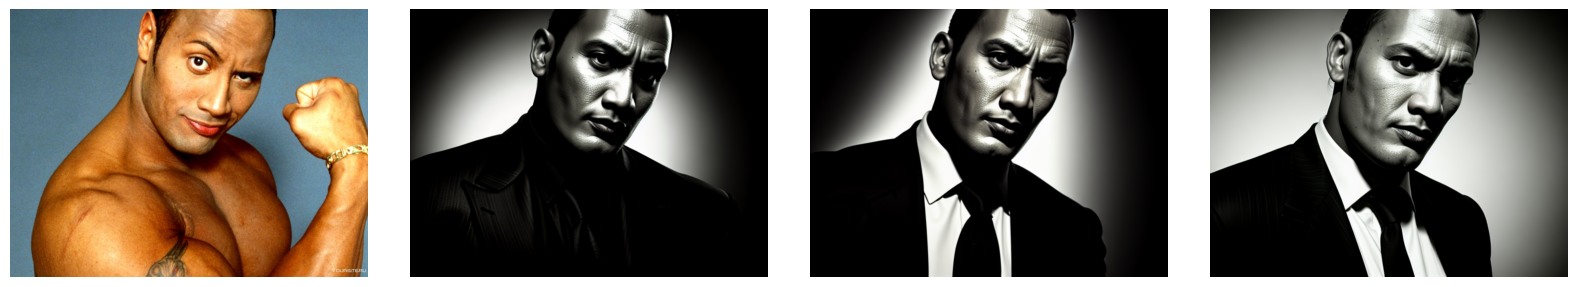

In [12]:
show_images(embed_images, n_rows=1, figsize=(16, 16))

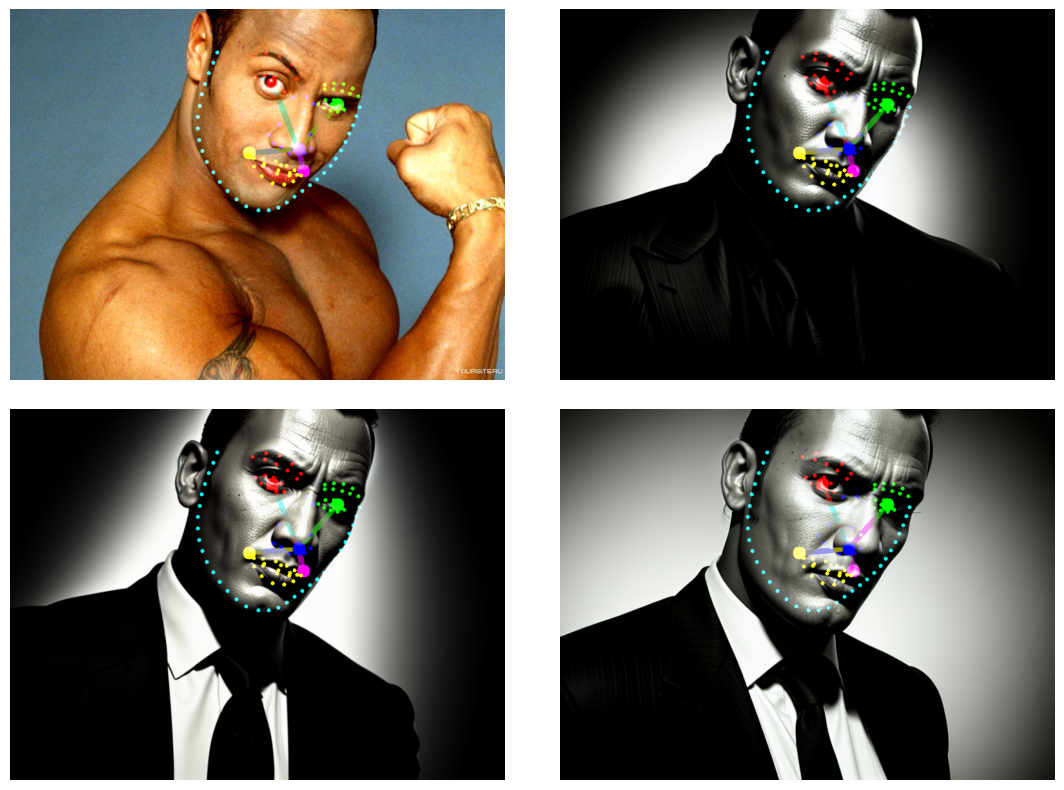

In [13]:
import cv2
import numpy as np


kp_images = []
control_image = np.array(controlnet_image)
control_image = cv2.resize(control_image, (width, height))
control_mask = control_image > 64

for gen_image in [x for x in embed_images]:
    gen_image = np.array(gen_image)
    gen_image[control_mask] = control_image[control_mask]
    kp_images.append(gen_image)
    
show_images(kp_images, n_rows=2, figsize=(11, 8))